In [2]:
##Imports
%matplotlib inline
import requests
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import json
## This is to get the connection to the nba endpoints correctly (hot fix to work until they push changes)
headers = {
    'Host': 'stats.nba.com',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:61.0) Gecko/20100101 Firefox/61.0',
    'Accept': 'application/json, text/plain, */*',
    'Accept-Language': 'en-US,en;q=0.5',
    'Referer': 'https://stats.nba.com/',
    'Accept-Encoding': 'gzip, deflate, br',
    'Connection': 'keep-alive',
    'x-nba-stats-origin': 'stats',
    'x-nba-stats-token': 'true'
}

In [3]:
from nba_api.stats.endpoints import playergamelog
## Lebron James
pgl = playergamelog.PlayerGameLog(player_id=2544, headers=headers)
gamelog = pgl.get_data_frames()[0]
gamelog.head()

,SEASON_ID,Player_ID,Game_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE
0,22019,2544,0021900417,"DEC 19, 2019",LAL @ MIL,L,37,8,19,0.421,...,12,12,11,0,0,4,5,21,-14,1
1,22019,2544,0021900402,"DEC 17, 2019",LAL @ IND,L,35,8,20,0.400,...,8,9,9,0,0,5,2,20,-9,1
2,22019,2544,0021900390,"DEC 15, 2019",LAL @ ATL,W,37,12,21,0.571,...,12,13,7,1,3,4,1,32,10,1
3,22019,2544,0021900374,"DEC 13, 2019",LAL @ MIA,W,37,11,22,0.500,...,7,9,12,1,0,8,2,28,9,1
4,22019,2544,0021900358,"DEC 11, 2019",LAL @ ORL,W,38,11,24,0.458,...,9,11,10,2,0,6,2,25,8,1


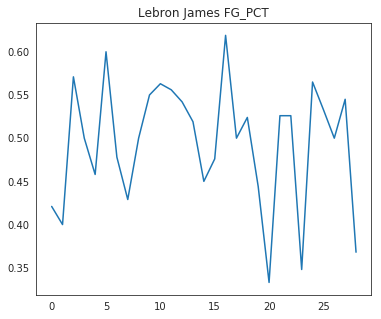

In [4]:
sns.set_style("white")
sns.set_color_codes()
plt.figure(figsize=(6,5))
plt.title('Lebron James FG_PCT')
plt.plot(range(gamelog.shape[0]), gamelog.FG_PCT)
plt.show()

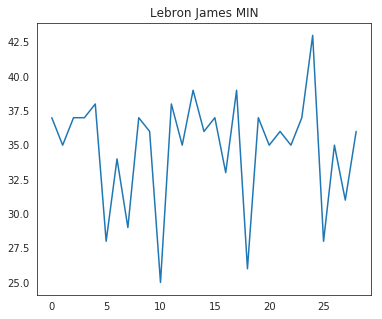

In [5]:
sns.set_style("white")
sns.set_color_codes()
plt.figure(figsize=(6,5))
plt.title('Lebron James MIN')
plt.plot(range(gamelog.shape[0]), gamelog.MIN)
plt.show()

In [10]:
print(gamelog.columns.values)

['SEASON_ID' 'Player_ID' 'Game_ID' 'GAME_DATE' 'MATCHUP' 'WL' 'MIN' 'FGM'
 'FGA' 'FG_PCT' 'FG3M' 'FG3A' 'FG3_PCT' 'FTM' 'FTA' 'FT_PCT' 'OREB' 'DREB'
 'REB' 'AST' 'STL' 'BLK' 'TOV' 'PF' 'PTS' 'PLUS_MINUS' 'VIDEO_AVAILABLE']


In [35]:
from enum import Enum

class ScoreType(Enum):
    STATS_WIN_INDEX = 'stat win index'
    STATS_WIN_SCORE = 'stat win'

In [43]:
### This is IDEA #2
### TODO: Experiment with different methods to get metrics, try to get like 4 different ones, so far 2/4.
### TODO: Construct this as a class so we can call these methods on a player object DESIGN LOLOLOL :/
### The class would have to have the enum type as a parmeter because its being passed in a lot of these comparing and plots

## This follows a fantasy points style ScoreType.STATS_WIN_INDEX
def determine_stats_win_index(player_game_data):
    
    stats_win_index = player_game_data.PTS + (2 * player_game_data.AST) 
    + (1.5 * player_game_data.REB) - 2 * (player_game_data.TOV + player_game_data.PF)
    + 2 * (player_game_data.STL + player_game_data.BLK)
    
    return stats_win_index

## This follows a custom built score dawg: ScoreType.STATS_WIN_SCORE
def determine_stats_win_score(player_game_data):
    ## Following are attributes of a game:
    scoring = (2 * player_game_data.FG_PCT + 3 * player_game_data.FG3_PCT + player_game_data.FT_PCT) * player_game_data.PTS / (2+3+1)
    ballhandling = 2 * player_game_data.AST - (player_game_data.FGA - player_game_data.FGM) - 1.2 * (player_game_data.TOV)
    defense = 5 * (player_game_data.STL + player_game_data.BLK) - 4 * (player_game_data.PF) + 2 * player_game_data.DREB
    stats_win_score = scoring + ballhandling + defense
    return stats_win_score

def plot_stats_to_winning(player_game_data, player_name, scoreType):
    swi = []
    if scoreType.value == 'stat win index':
        swi = determine_stats_win_index(player_game_data)
    elif scoreType.value == 'stat win':
        swi = determine_stats_win_score(player_game_data)
        
    plt.scatter(swi, player_game_data.PLUS_MINUS, s=300, c=player_game_data.FG_PCT)
    plt.title(player_name + ". His score is: " + str(determine_player_winning_score(player_game_data, scoreType)))
    plt.show()

In [44]:
def determine_player_winning_score(player_game_data, scoreType):
    swi = []
    if scoreType.value == 'stat win index':
        swi = determine_stats_win_index(player_game_data)
    elif scoreType.value == 'stat win':
        swi = determine_stats_win_score(player_game_data)
    try:
        return np.round(np.mean(player_game_data.PLUS_MINUS.values * swi.values * player_game_data.MIN.values / 48),2)
    except ZeroDivisionError:
        return 0.01

def rank_player_winning_scores(team, efficiencies, n, scoreType):
    top_n_players = sorted(efficiencies.keys(), reverse=True)
    print(top_n_players)
    print("Top " + str(n) + " players on the " + team)
    for i in range(n):
        print(str(i) + ". " + efficiencies[top_n_players[i]] + " has a " + scoreType.value + " score of: " + str(top_n_players[i]))

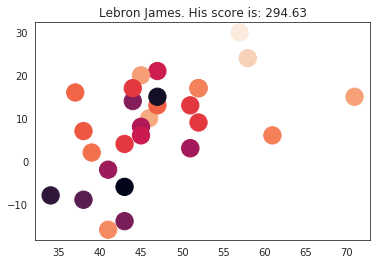

In [38]:
plot_stats_to_winning(gamelog, 'Lebron James', ScoreType.STATS_WIN_INDEX)

In [26]:
## Build the team name to team_id map
from nba_api.stats.static import teams
nba_teams = teams.get_teams()
list_teams = ['ATL', 'BOS', 'CLE', 'NOP', 'CHI', 'DAL', 'DEN', 'GSW', 'HOU', 'LAC', 'LAL'
        , 'MIA', 'MIL', 'MIN', 'BKN', 'NYK', 'ORL', 'IND', 'PHI', 'PHX', 'POR', 'SAC'
        , 'SAS', 'OKC', 'TOR', 'UTA', 'MEM', 'WAS', 'DET', 'CHA']
i = 0
team_to_id = {}
for t in list_teams:
    team_to_id.update({t: nba_teams[i]['id']})
    i += 1
print(team_to_id)

{'ATL': 1610612737, 'BOS': 1610612738, 'CLE': 1610612739, 'NOP': 1610612740, 'CHI': 1610612741, 'DAL': 1610612742, 'DEN': 1610612743, 'GSW': 1610612744, 'HOU': 1610612745, 'LAC': 1610612746, 'LAL': 1610612747, 'MIA': 1610612748, 'MIL': 1610612749, 'MIN': 1610612750, 'BKN': 1610612751, 'NYK': 1610612752, 'ORL': 1610612753, 'IND': 1610612754, 'PHI': 1610612755, 'PHX': 1610612756, 'POR': 1610612757, 'SAC': 1610612758, 'SAS': 1610612759, 'OKC': 1610612760, 'TOR': 1610612761, 'UTA': 1610612762, 'MEM': 1610612763, 'WAS': 1610612764, 'DET': 1610612765, 'CHA': 1610612766}


In [39]:
# Make API Call for players across all seasons for a particular franchise
from nba_api.stats.endpoints import franchiseplayers

def get_winning_stats_per_team(team, scoreType):
    fp = franchiseplayers.FranchisePlayers(team_id=team_to_id[team], headers=headers)
    PLAYERS = fp.get_data_frames()[0]
    # Build the list of players in the 2019-2020 season
    active_players = PLAYERS.loc[PLAYERS['ACTIVE_WITH_TEAM'] == 1]
    ids_per_team = active_players['PERSON_ID'].values
    player_names = active_players['PLAYER'].values
    print(player_names)
    players_per_team = dict(zip(ids_per_team, player_names))
    effectiveness = []
    players = []
    ## Get the winning_stats_for a player
    for player in players_per_team:
        pgl = playergamelog.PlayerGameLog(player_id=player, headers=headers)
        player_game_data = pgl.get_data_frames()[0]
        effectiveness.append(determine_player_winning_score(player_game_data, scoreType))
        players.append(players_per_team[player])
        #plot_stats_to_winning(player_game_data, players_per_team[player], scoreType)
        
    effect = dict(zip(effectiveness, players)) 
    rank_player_winning_scores(team, effect, 5, scoreType)

In [40]:
get_winning_stats_per_team("LAL", ScoreType.STATS_WIN_INDEX)

['LeBron James' 'Dwight Howard' 'Rajon Rondo' 'Jared Dudley'
 'JaVale McGee' 'Danny Green' 'Avery Bradley' 'Anthony Davis'
 'Kentavious Caldwell-Pope' 'Troy Daniels' 'Quinn Cook' 'Alex Caruso'
 'Kyle Kuzma' 'Kostas Antetokounmpo' 'Talen Horton-Tucker']
[294.63, 173.53, 58.95, 45.52, 40.0, 37.09, 27.81, 27.23, 21.64, 20.67, 14.55, 3.37, 2.18, 0.0]
Top 5 players on the LAL
0. LeBron James has a stat win index score of: 294.63
1. Anthony Davis has a stat win index score of: 173.53
2. Rajon Rondo has a stat win index score of: 58.95
3. Kyle Kuzma has a stat win index score of: 45.52
4. Danny Green has a stat win index score of: 40.0


In [41]:
get_winning_stats_per_team("LAL", ScoreType.STATS_WIN_SCORE)

['LeBron James' 'Dwight Howard' 'Rajon Rondo' 'Jared Dudley'
 'JaVale McGee' 'Danny Green' 'Avery Bradley' 'Anthony Davis'
 'Kentavious Caldwell-Pope' 'Troy Daniels' 'Quinn Cook' 'Alex Caruso'
 'Kyle Kuzma' 'Kostas Antetokounmpo' 'Talen Horton-Tucker']
[222.73, 156.0, 71.45, 42.63, 35.87, 35.08, 28.59, 26.52, 17.98, 16.64, 6.98, 3.26, 0.78, 0.08, 0.0]
Top 5 players on the LAL
0. LeBron James has a stat win score of: 222.73
1. Anthony Davis has a stat win score of: 156.0
2. Rajon Rondo has a stat win score of: 71.45
3. JaVale McGee has a stat win score of: 42.63
4. Kyle Kuzma has a stat win score of: 35.87


In [42]:
get_winning_stats_per_team("MIA", ScoreType.STATS_WIN_INDEX)
get_winning_stats_per_team("MIA", ScoreType.STATS_WIN_SCORE)

['Udonis Haslem' 'Goran Dragic' 'James Johnson' 'Jimmy Butler'
 'Dion Waiters' 'Meyers Leonard' 'Kelly Olynyk' 'Justise Winslow'
 'Derrick Jones Jr.' 'Bam Adebayo' 'Duncan Robinson' 'Daryl Macon'
 'Kendrick Nunn' 'Tyler Herro' 'KZ Okpala' 'Chris Silva']


/home/vishnu/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


[241.06, 139.7, 115.86, 102.19, 67.51, 39.36, 33.09, 27.6, 26.73, 26.6, 4.56, 0.89, 0.27, 0.01, 0.0, -1.06]
Top 5 players on the MIA
0. Jimmy Butler has a stat win index score of: 241.06
1. Bam Adebayo has a stat win index score of: 139.7
2. Justise Winslow has a stat win index score of: 115.86
3. Kendrick Nunn has a stat win index score of: 102.19
4. Duncan Robinson has a stat win index score of: 67.51
['Udonis Haslem' 'Goran Dragic' 'James Johnson' 'Jimmy Butler'
 'Dion Waiters' 'Meyers Leonard' 'Kelly Olynyk' 'Justise Winslow'
 'Derrick Jones Jr.' 'Bam Adebayo' 'Duncan Robinson' 'Daryl Macon'
 'Kendrick Nunn' 'Tyler Herro' 'KZ Okpala' 'Chris Silva']
[289.65, 139.42, 60.09, 54.45, 44.4, 42.98, 33.46, 31.8, 25.0, 14.13, 1.5, 0.93, 0.01, -0.02, -0.3, -23.37]
Top 5 players on the MIA
0. Jimmy Butler has a stat win score of: 289.65
1. Bam Adebayo has a stat win score of: 139.42
2. Justise Winslow has a stat win score of: 60.09
3. Meyers Leonard has a stat win score of: 54.45
4. Kendrick 

In [45]:
get_winning_stats_per_team("LAC", ScoreType.STATS_WIN_INDEX)
get_winning_stats_per_team("LAC", ScoreType.STATS_WIN_SCORE)

['Lou Williams' 'Patrick Beverley' 'Paul George' 'Patrick Patterson'
 'Kawhi Leonard' 'Maurice Harkless' 'JaMychal Green' 'Rodney McGruder'
 'Montrezl Harrell' 'Ivica Zubac' 'Johnathan Motley' 'Derrick Walton Jr.'
 'Jerome Robinson' 'Landry Shamet' 'Terance Mann' 'Mfiondu Kabengele']
[222.16, 150.98, 109.56, 95.68, 53.66, 35.8, 30.62, 22.77, 18.01, 16.62, 14.48, 11.64, 9.96, 4.98, 1.9, -0.38]
Top 5 players on the LAC
0. Kawhi Leonard has a stat win index score of: 222.16
1. Paul George has a stat win index score of: 150.98
2. Montrezl Harrell has a stat win index score of: 109.56
3. Lou Williams has a stat win index score of: 95.68
4. Patrick Beverley has a stat win index score of: 53.66
['Lou Williams' 'Patrick Beverley' 'Paul George' 'Patrick Patterson'
 'Kawhi Leonard' 'Maurice Harkless' 'JaMychal Green' 'Rodney McGruder'
 'Montrezl Harrell' 'Ivica Zubac' 'Johnathan Motley' 'Derrick Walton Jr.'
 'Jerome Robinson' 'Landry Shamet' 'Terance Mann' 'Mfiondu Kabengele']
[163.74, 106.64, 8

In [46]:
get_winning_stats_per_team("BOS", ScoreType.STATS_WIN_INDEX)
get_winning_stats_per_team("BOS", ScoreType.STATS_WIN_SCORE)

['Gordon Hayward' 'Enes Kanter' 'Kemba Walker' 'Brad Wanamaker'
 'Marcus Smart' 'Jaylen Brown' 'Jayson Tatum' 'Semi Ojeleye'
 'Daniel Theis' 'Carsen Edwards' 'Robert Williams III' 'Tacko Fall'
 'Romeo Langford' 'Tremont Waters' 'Grant Williams' 'Vincent Poirier'
 'Javonte Green']
[164.7, 161.27, 111.06, 108.33, 102.37, 64.28, 25.31, 23.52, 16.28, 14.08, 6.72, 3.19, 2.28, 2.16, 1.46, 1.01, -1.9]
Top 5 players on the BOS
0. Kemba Walker has a stat win index score of: 164.7
1. Jayson Tatum has a stat win index score of: 161.27
2. Jaylen Brown has a stat win index score of: 111.06
3. Tremont Waters has a stat win index score of: 108.33
4. Gordon Hayward has a stat win index score of: 102.37
['Gordon Hayward' 'Enes Kanter' 'Kemba Walker' 'Brad Wanamaker'
 'Marcus Smart' 'Jaylen Brown' 'Jayson Tatum' 'Semi Ojeleye'
 'Daniel Theis' 'Carsen Edwards' 'Robert Williams III' 'Tacko Fall'
 'Romeo Langford' 'Tremont Waters' 'Grant Williams' 'Vincent Poirier'
 'Javonte Green']
[125.38, 118.03, 101.12

In [47]:
get_winning_stats_per_team("TOR", ScoreType.STATS_WIN_INDEX)
get_winning_stats_per_team("TOR", ScoreType.STATS_WIN_SCORE)

['Kyle Lowry' 'Marc Gasol' 'Serge Ibaka' 'Stanley Johnson'
 'Rondae Hollis-Jefferson' 'Norman Powell' 'Malcolm Miller'
 'Patrick McCaw' 'Pascal Siakam' 'Fred VanVleet' 'OG Anunoby'
 'Chris Boucher' 'Shamorie Ponds' 'Oshae Brissett' 'Terence Davis'
 'Dewan Hernandez' 'Matt Thomas']
[189.61, 114.3, 76.47, 56.35, 52.81, 44.04, 31.0, 18.52, 15.71, 14.0, 11.5, 10.64, 2.48, 0.67, 0.09, 0.08, -0.19]
Top 5 players on the TOR
0. Pascal Siakam has a stat win index score of: 189.61
1. Fred VanVleet has a stat win index score of: 114.3
2. OG Anunoby has a stat win index score of: 76.47
3. Kyle Lowry has a stat win index score of: 56.35
4. Marc Gasol has a stat win index score of: 52.81
['Kyle Lowry' 'Marc Gasol' 'Serge Ibaka' 'Stanley Johnson'
 'Rondae Hollis-Jefferson' 'Norman Powell' 'Malcolm Miller'
 'Patrick McCaw' 'Pascal Siakam' 'Fred VanVleet' 'OG Anunoby'
 'Chris Boucher' 'Shamorie Ponds' 'Oshae Brissett' 'Terence Davis'
 'Dewan Hernandez' 'Matt Thomas']
[119.06, 114.75, 86.76, 67.84, 46.5

In [48]:
get_winning_stats_per_team("PHI", ScoreType.STATS_WIN_INDEX)
get_winning_stats_per_team("PHI", ScoreType.STATS_WIN_SCORE)

['Al Horford' 'Tobias Harris' 'Mike Scott' "Kyle O'Quinn" 'Trey Burke'
 'James Ennis III' 'Raul Neto' 'Norvel Pelle' 'Joel Embiid'
 'Josh Richardson' 'Ben Simmons' 'Furkan Korkmaz' 'Jonah Bolden'
 'Shake Milton' 'Zhaire Smith' 'Matisse Thybulle']
[99.04, 88.49, 80.71, 75.71, 74.29, 46.11, 24.23, 19.1, 17.63, 8.7, 4.32, 2.98, 2.22, 0.42, 0.01, -0.04]
Top 5 players on the PHI
0. Joel Embiid has a stat win index score of: 99.04
1. Ben Simmons has a stat win index score of: 88.49
2. Josh Richardson has a stat win index score of: 80.71
3. Al Horford has a stat win index score of: 75.71
4. Tobias Harris has a stat win index score of: 74.29
['Al Horford' 'Tobias Harris' 'Mike Scott' "Kyle O'Quinn" 'Trey Burke'
 'James Ennis III' 'Raul Neto' 'Norvel Pelle' 'Joel Embiid'
 'Josh Richardson' 'Ben Simmons' 'Furkan Korkmaz' 'Jonah Bolden'
 'Shake Milton' 'Zhaire Smith' 'Matisse Thybulle']
[98.63, 97.49, 83.65, 70.28, 46.04, 45.38, 36.1, 11.55, 11.34, 10.09, 8.11, 5.96, 0.29, 0.01, -1.61, -4.04]
Top